**/!\ Attention, on utilise la dernière version de Keras dans ce notebook**

# Paramétrage

## Librairies

In [ ]:
# partie spécifique Google Colab
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
# partie spécifique Google Colab
'''
If you install TensorFlow, critically, you should reinstall Keras 3 afterwards.
This is a temporary step while TensorFlow is pinned to Keras 2, and will no longer be necessary after TensorFlow 2.16.
The cause is that tensorflow==2.15 will overwrite your Keras installation with keras==2.15.
'''
!pip install --upgrade keras

In [ ]:
# partie spécifique Google Colab
!pip install rasterio plotly scikit-image

In [ ]:
import rasterio
import numpy as np
import glob
import plotly.express as px
import plotly.graph_objs as go
import cv2
import pandas as pd
import geopandas as gpd
import tqdm
from datetime import date
from google.colab import drive
import random
import matplotlib.pyplot as plt
import shapely
import os
import math
import skimage as ski
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

import tensorflow as tf

import keras
from keras.models import Sequential, load_model
from keras.utils import load_img, img_to_array, array_to_img


## Fonctions

Se référer aux notebooks ["tests Keras"](https://colab.research.google.com/drive/1rZviL4G2UEhc_UY0lqy9alDLL9s4uxLz#scrollTo=58UtzFyg9sg2) et ["DeepLabV3+ Keras"](https://colab.research.google.com/drive/1qwP5Z7ctBGY01jEvi3dFmI53I3VvcndZ?usp=sharing) pour la version originale des fonctions, ainsi que les modules suivants :

+ [calcul_metriques.py](https://github.com/DataScientest-Studio/juil23_cds_construction_illegale/blob/main/notebooks/calcul_metriques.py)
+ [3.1-Moez-Comparaison_masques.py](https://github.com/DataScientest-Studio/juil23_cds_construction_illegale/blob/main/notebooks/3.1-Moez-Comparaison_masques.py)

In [ ]:
def read_image(image_path, mask = False, binary = True, resnet50_preprocess = True):
  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels = 1)
    if binary:
      image = tf.where(tf.math.greater(image, 0), 1, 0)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images = image, size = resolution)
  else:
    image = tf.image.decode_png(image, channels = 3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images = image, size = resolution)
    if resnet50_preprocess:
      # on reproduit le résultat de la fonction tf.keras.applications.resnet50.preprocess_input
      image = image[..., ::-1] - tf.constant([103.939, 116.779, 123.68])
  return image

In [ ]:
def show_segmentation_results(model, i_image, df_decoupe, seuil = 0.85):
  '''
  fonction qui permet d'afficher côte à côte :
  - le masque prédit par le modèle
  - le masque de départ, avec le contour prédit par le modèle
  - l'image de départ, avec le contour prédit par le modèle
  '''
  val_image = read_image(images_path + '/' + df_decoupe['fichier_img'].values[i_image])
  mask_target = read_image(images_path + '/' + df_decoupe['fichier_mask'].values[i_image], mask = True)
  mask_target = np.where(mask_target > 0, 1, 0)

  mask = model.predict(np.expand_dims(val_image, 0), verbose = 0)[0]
  # on récupère le numéro de la classe prédite, c'est-à-dire celle
  # dont le softmax est le plus élevé
  mask = np.argmax(np.where(mask > seuil, 1, 0), axis = -1)
  # la classe du masque est 1 : on cherche le contour "à l'intérieur"
  mask_contours = ski.measure.find_contours(image = mask == 1)
  print('{} forme(s) détectée(s) pour {} forme(s) présente(s)'.format(
      len(mask_contours),
      df_decoupe['formes'].values[i_image]))

  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
  ax1.imshow(mask*100)
  ax2.imshow(mask_target*100)
  ax3.imshow(array_to_img(val_image))
  for contour in mask_contours:
      ax2.plot(contour[:, 1], contour[:, 0], linewidth=1, color = 'red')
      ax3.plot(contour[:, 1], contour[:, 0], linewidth=1, color = '#f0fc03')
  for ax in (ax1, ax2, ax3):
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])

  plt.show()

In [ ]:
def calcul_performances(i_image, df_metrique, binary = True, seuil = 0.85):
  val_image = read_image(images_path + '/' + df_metrique['fichier_img'].values[i_image])
  mask_target = read_image(images_path + '/' + df_metrique['fichier_mask'].values[i_image], mask = True)
  if binary:
    mask_target = tf.where(tf.math.greater(mask_target, 0), 1, 0)
  mask_target = tf.reshape(mask_target, resolution)
  mask_raw = model.predict(tf.expand_dims(val_image, 0), verbose = 0)
  mask = tf.reshape(tf.argmax(tf.where(mask_raw > seuil, 1, 0), axis = -1), resolution)

  iou.update_state(mask_target, mask)
  m_IoU = iou.result().numpy()

  m_scce = scce(mask_target, tf.reshape(mask_raw, resolution + (2,))).numpy()

  sca.update_state(mask_target, mask)
  m_sca = sca.result().numpy()

  return m_IoU, m_sca, m_scce

## Données

In [ ]:
# partie spécifique Google Colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# partie spécifique Google Colab
!mkdir -p /content/data/decoupe_final
!cp /content/drive/MyDrive/data/DST/df_decoupe_final.csv /content/data/decoupe_final/df_decoupe_final.csv
!unzip /content/drive/MyDrive/data/DST/decoupe_final.zip -d /content/data/decoupe_final

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.cpg  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.dbf  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.jp2  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.prj  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.shp  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.shx  
 extracting: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_data.jpg  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_data.jpg.aux.xml  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_label.png  
  inflating: /content/data/decoupe

In [ ]:
data_path = '/content/data/decoupe_final'
images_path = '/content/data/decoupe_final/decoupe_final'
df_decoupe = pd.read_csv(data_path + '/df_decoupe_final.csv')
df_decoupe.head()

NameError: name 'pd' is not defined

# Statistiques

In [ ]:
model = load_model('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_model_20240105.keras')
resolution = (512, 512)

In [ ]:
scce = keras.losses.SparseCategoricalCrossentropy()
sca = keras.metrics.SparseCategoricalAccuracy()
iou = keras.metrics.MeanIoU(2)

df_metrique = df_decoupe.sample(10)

metriques = []
for i in tqdm.tqdm(range(df_metrique.shape[0])):
    metriques.append(list(calcul_performances(i, df_metrique, binary = True, seuil = 0.85)))

df_metrique['IoU'] = np.array(metriques)[:,0]
df_metrique['sca'] = np.array(metriques)[:,1]
df_metrique['scce'] = np.array(metriques)[:,2]

100%|██████████| 10/10 [00:54<00:00,  5.49s/it]


In [ ]:
df_metrique

,dalle_X,dalle_Y,X,Y,X_size,Y_size,fichier_raster,fichier_img,fichier_mask,fichier_shapes,formes,multi,erreur,IoU,sca,scce
5953,13,3,842600.0,6509200.0,1000,1000,69-2020_3_842600.0_13_6509200.0_0.jp2,69-2020_3_842600.0_13_6509200.0_0_data.jpg,69-2020_3_842600.0_13_6509200.0_0_label.png,69-2020_3_842600.0_13_6509200.0_0.shp,0,0,0,1.000000,1.000000,0.000185
3506,15,6,833000.0,6518600.0,1000,1000,69-2020_6_833000.0_15_6518600.0_0.jp2,69-2020_6_833000.0_15_6518600.0_0_data.jpg,69-2020_6_833000.0_15_6518600.0_0_label.png,69-2020_6_833000.0_15_6518600.0_0.shp,0,0,0,1.000000,1.000000,0.000689
3836,3,11,835600.0,6507600.0,1000,1000,69-2020_11_835600.0_3_6507600.0_0.jp2,69-2020_11_835600.0_3_6507600.0_0_data.jpg,69-2020_11_835600.0_3_6507600.0_0_label.png,69-2020_11_835600.0_3_6507600.0_0.shp,0,0,0,1.000000,1.000000,0.000365
3747,24,22,834800.0,6515400.0,1000,1000,69-2020_22_834800.0_24_6515400.0_9.jp2,69-2020_22_834800.0_24_6515400.0_9_data.jpg,69-2020_22_834800.0_24_6515400.0_9_label.png,69-2020_22_834800.0_24_6515400.0_9.shp,9,0,0,0.725692,0.859152,0.058512
7171,11,21,842200.0,6515600.0,1000,1000,69-2020_21_842200.0_11_6515600.0_18.jp2,69-2020_21_842200.0_11_6515600.0_18_data.jpg,69-2020_21_842200.0_11_6515600.0_18_label.png,69-2020_21_842200.0_11_6515600.0_18.shp,18,0,0,0.676353,0.807489,0.171061
4776,16,1,838200.0,6514600.0,1000,1000,69-2020_1_838200.0_16_6514600.0_12.jp2,69-2020_1_838200.0_16_6514600.0_12_data.jpg,69-2020_1_838200.0_16_6514600.0_12_label.png,69-2020_1_838200.0_16_6514600.0_12.shp,12,0,0,0.664147,0.787756,0.100911
2864,14,14,832800.0,6512000.0,1000,1000,69-2020_14_832800.0_14_6512000.0_0.jp2,69-2020_14_832800.0_14_6512000.0_0_data.jpg,69-2020_14_832800.0_14_6512000.0_0_label.png,69-2020_14_832800.0_14_6512000.0_0.shp,0,0,0,0.666018,0.818077,0.000317
1692,17,17,828400.0,6516400.0,1000,1000,69-2020_17_828400.0_17_6516400.0_0.jp2,69-2020_17_828400.0_17_6516400.0_0_data.jpg,69-2020_17_828400.0_17_6516400.0_0_label.png,69-2020_17_828400.0_17_6516400.0_0.shp,0,0,0,0.667417,0.840817,0.001193
4264,20,14,839000.0,6507000.0,1000,1000,69-2020_14_839000.0_20_6507000.0_64.jp2,69-2020_14_839000.0_20_6507000.0_64_data.jpg,69-2020_14_839000.0_20_6507000.0_64_label.png,69-2020_14_839000.0_20_6507000.0_64.shp,64,0,0,0.700773,0.757371,0.137229
8,0,8,825000.0,6508200.0,1000,1000,69-2020_8_825000.0_0_6508200.0_0.jp2,69-2020_8_825000.0_0_6508200.0_0_data.jpg,69-2020_8_825000.0_0_6508200.0_0_label.png,69-2020_8_825000.0_0_6508200.0_0.shp,0,0,0,0.702037,0.781634,0.000166


# Détection de contours

In [ ]:
model = load_model('/content/drive/MyDrive/DataScientest/Keras/DeeplabV3Plus_model_20240105.keras')
resolution = (512, 512)


8 forme(s) détectée(s) pour 11 forme(s) présente(s)


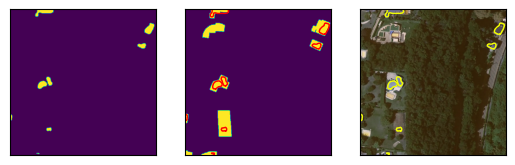

In [ ]:
i_image = 5698
show_segmentation_results(model, i_image, df_decoupe)

In [ ]:
seuil = 0.5
val_image = read_image(images_path + '/' + df_decoupe['fichier_img'].values[i_image])
mask_target = read_image(images_path + '/' + df_decoupe['fichier_mask'].values[i_image], mask = True)
mask_target = np.where(mask_target > 0, 1, 0)
mask = model.predict(np.expand_dims(val_image, 0), verbose = 0)[0]
mask = np.argmax(np.where(mask > seuil, 1, 0), axis = -1)
mask_contours = ski.measure.find_contours(image = mask == 1)


<Axes: >

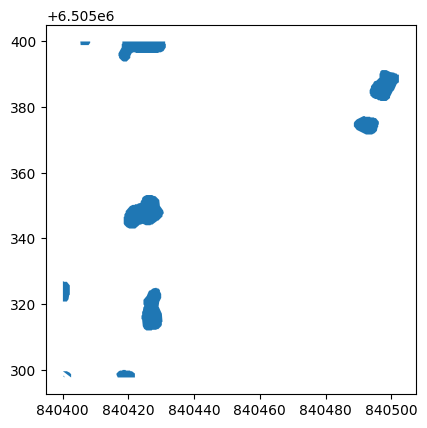

In [ ]:
with rasterio.open(images_path + '/' + df_decoupe['fichier_raster'].values[i_image]) as raster:
  # création du convertisseur pour passer des coordonnées en pixels
  raster_transform = raster.transform
  raster_transformer = rasterio.transform.AffineTransformer(raster_transform)
  shapes_predict = []
  # parcours de tous les contours prédits
  for contour in mask_contours:
    # on crée le polygone
    polygon = approximate_polygon(contour, tolerance=0.5)
    # on tranforme en coordonnées
    xy_polygon = raster_transformer.xy(polygon[:,0], polygon[:,1])
    # on crée le polygone
    shapes_predict.append(shapely.Polygon(np.array(xy_polygon).transpose()))
  s = gpd.GeoSeries(shapes_predict, crs=2154)
gpd.GeoDataFrame(geometry = s, crs=2154).plot()

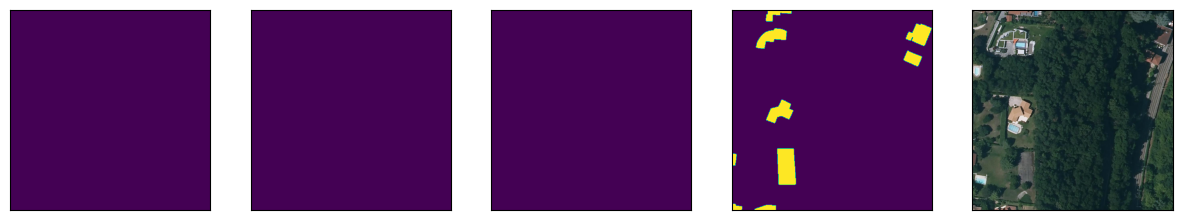

In [ ]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(15, 15))
ax1.imshow(mask*100)
ax2.imshow(mask*100)
ax3.imshow(mask*100)
ax4.imshow(val_target*100)
ax5.imshow(array_to_img(val_image_array))
for contour in mask_contours:
  bbox = cv2.boxPoints(cv2.minAreaRect(np.float32(contour)))
  bbox = np.append(bbox, [bbox[0]], axis = 0)
  ax2.plot(bbox[:, 1], bbox[:, 0], linewidth=1, color = 'red')
  polygon = approximate_polygon(contour, tolerance=0.5)
  ax3.plot(polygon[:, 1], polygon[:, 0], linewidth=1, color = 'red')
  ax4.plot(contour[:, 1], contour[:, 0], linewidth=1, color = 'red')
  ax5.plot(contour[:, 1], contour[:, 0], linewidth=1, color = '#f0fc03')
for ax in (ax1, ax2, ax3, ax4, ax5):
  ax.axis('image')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()